### Section 5.3, Connection to Compressed Sensing, page 14.

- Original problem == multi-frame video sequence.
- Here, we compare both conditional and unconditional Langevin sampling.
- Note that conditional Langevin sampling in THIS experiment HAS oracle capabilities (KNOWS exact location of unmasked datapoints).

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(1)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,15)

In [3]:
# X ~ N(x; mu, sigma)
# Generate a 3-frame video sequence (32 x 32) with 2 colour channels.

shape = (3, 32, 32)
rng = default_rng()

mu = np.array([3, 5])
sigma = np.eye(mu.shape[0]) * 3
data = rng.multivariate_normal(mean=mu, cov=sigma, size=shape)

data.shape

(3, 32, 32, 2)

In [22]:
# Generate y = Ax, where A is sub-sampling mask

mask = rng.integers(0, 2, shape)[..., None]
mask = mask.repeat(2, -1)
masked = mask * data

bool_mask = np.ma.make_mask(mask[..., 0]) # Boolean mask to extract observed/unmasked datapoints only

meas = np.sum(masked, axis=0)

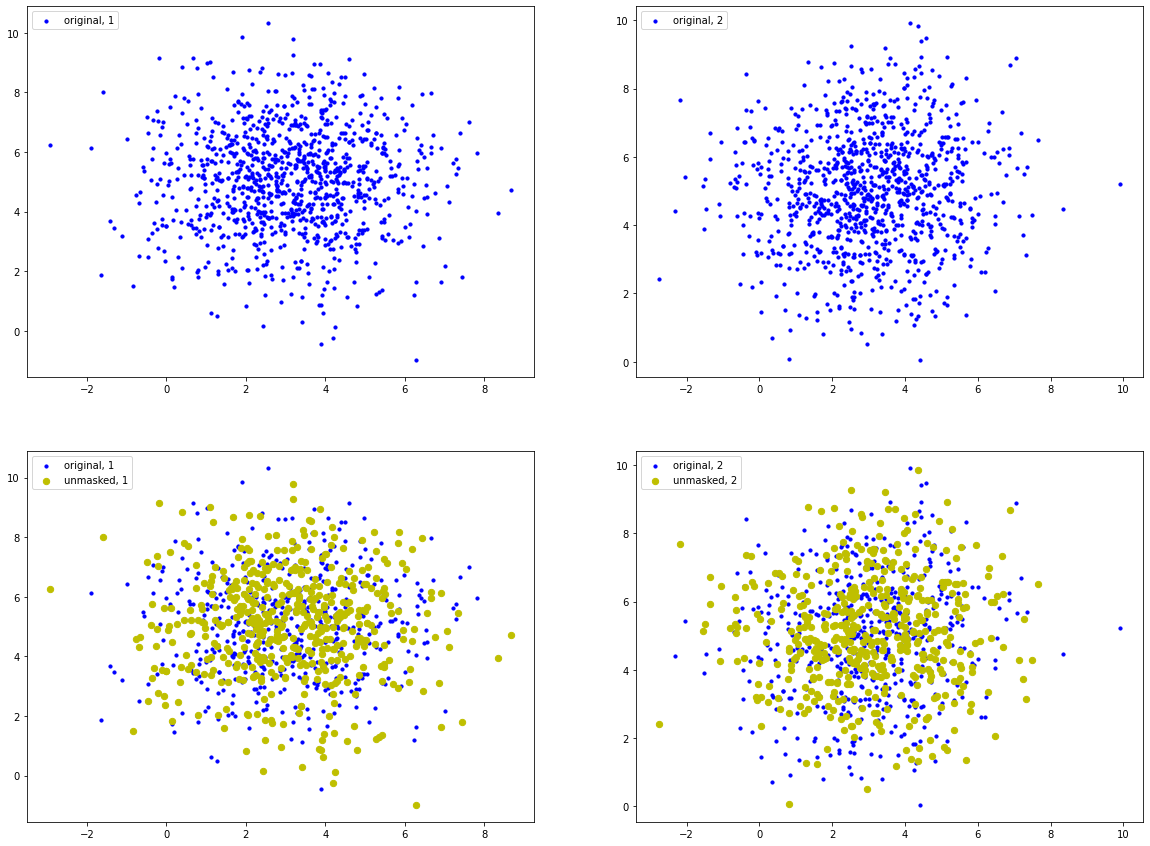

In [24]:
# Top-left diagram shows overall distribution of the 1st frame in the generated video-sequence.
# Top-right diagram shows overall distribution of the 2nd frame in the generated video-sequence.
# Bottom-left diagram highlights UNMASKED/OBSERVED data points (YELLOW) of the 1st frame in the generated video-sequence.
# Bottom-right diagram highlights UNMASKED/OBSERVED data points (YELLOW) of the 2nd frame in the generated video-sequence.

def scatter_plot(data, meas, masked):
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    x_vec = np.ravel(data[0, :, :, 0])
    y_vec = np.ravel(data[0, :, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 1')
    ax1.legend(loc='upper left')
    ax3.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 1')
    
    x_vec = np.ravel(data[1, :, :, 0])
    y_vec = np.ravel(data[1, :, :, 1])
    ax2.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 2')
    ax2.legend(loc='upper left')
    ax4.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 2')
    
    x_vec = np.ravel(masked[0, :, :, 0][bool_mask[0]])
    y_vec = np.ravel(masked[0, :, :, 1][bool_mask[0]])
    ax3.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='unmasked, 1', facecolor='none')
    
    x_vec = np.ravel(masked[1, :, :, 0][bool_mask[1]])
    y_vec = np.ravel(masked[1, :, :, 1][bool_mask[1]])
    ax4.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='unmasked, 2', facecolor='none')
    
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper left')

scatter_plot(data, meas, masked)

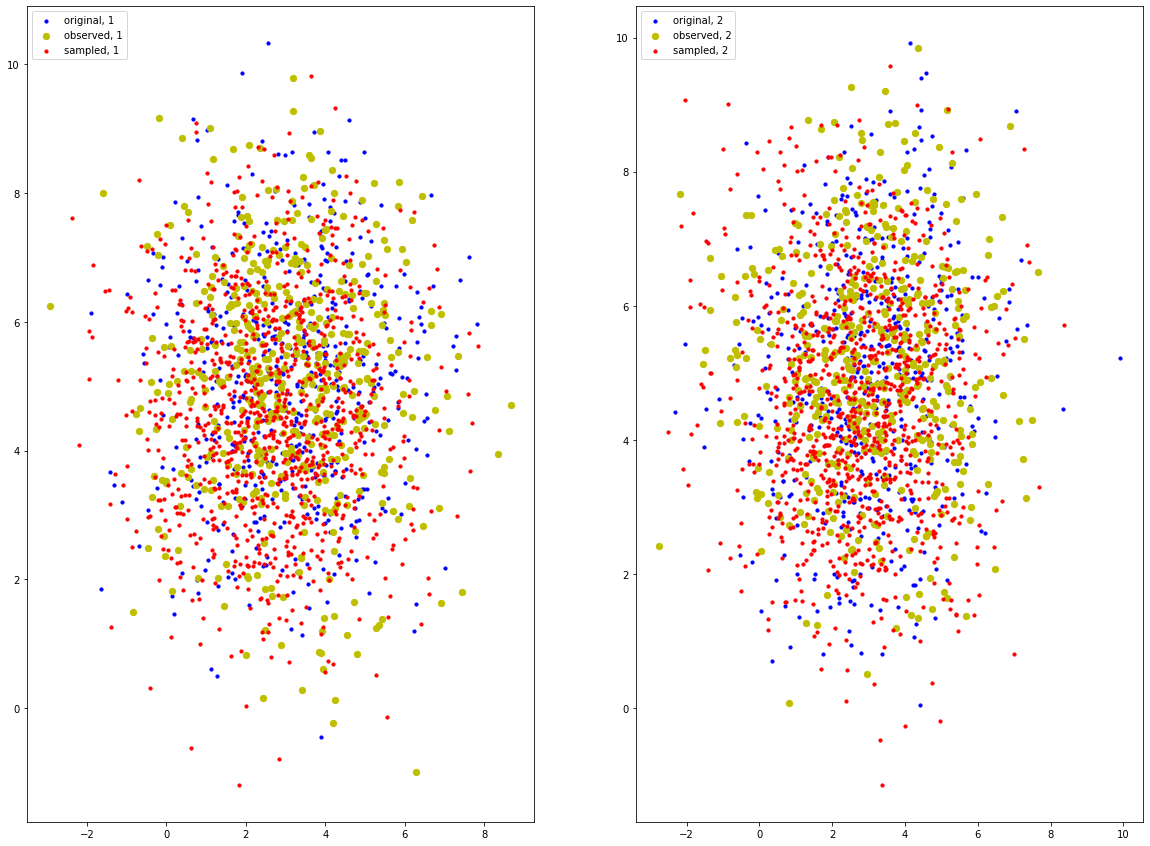

In [25]:
# Apply unconditional Langevin sampling to recover the original (generated) data
# Datapoints highlighted in RED represents sampled datapoints.

def get_score_normal(x):
    sigma = np.array([3, 3])
    mu = np.array([3, 5])
    score = (x - mu[None, None, :]) / sigma[None, None, :]
    return -1 * score 

      
def uncond_langevin_sampler(step_size=0.01):
    mean = np.array([0, 0])
    cov = np.eye(mean.shape[0])
    x = np.zeros(shape)[... , None]
    x = np.repeat(x, 2, -1)
    
    for _ in range(1500):
        score = get_score_normal(x)
        x = x + step_size * score / 2 + np.sqrt(step_size) * rng.multivariate_normal(mean=mean, cov=cov, size=shape)
    
    return x


def scatter_plot(data, sampled):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    x_vec = np.ravel(data[0, :, :, 0])
    y_vec = np.ravel(data[0, :, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 1')

    x_vec = np.ravel(data[1, :, :, 0])
    y_vec = np.ravel(data[1, :, :, 1])
    ax2.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 2')
    
    x_vec = np.ravel(masked[0, :, :, 0][bool_mask[0]])
    y_vec = np.ravel(masked[0, :, :, 1][bool_mask[0]])
    ax1.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='observed, 1', facecolor='none')
    
    x_vec = np.ravel(masked[1, :, :, 0][bool_mask[1]])
    y_vec = np.ravel(masked[1, :, :, 1][bool_mask[1]])
    ax2.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='observed, 2', facecolor='none')
    
    x_vec = np.ravel(sampled[0, :, :, 0])
    y_vec = np.ravel(sampled[0, :, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='r', marker="o", label='sampled, 1', facecolor='none')
    ax1.legend(loc='upper left')
   
    x_vec = np.ravel(sampled[1, :, :, 0])
    y_vec = np.ravel(sampled[1, :, :, 1])
    ax2.scatter(x_vec,y_vec, s=10, c='r', marker="o", label='sampled, 2', facecolor='none')
    ax2.legend(loc='upper left')
    

x_hat = uncond_langevin_sampler()
scatter_plot(data, x_hat)

# Notice how the red points (sampled) are inconsistent with the blue/yellow (original) points,
# although the red points still follows the original data distribution (Gaussian).

# Ideally, we want the red points to lie DIRECTLY above the blue/yellow points.

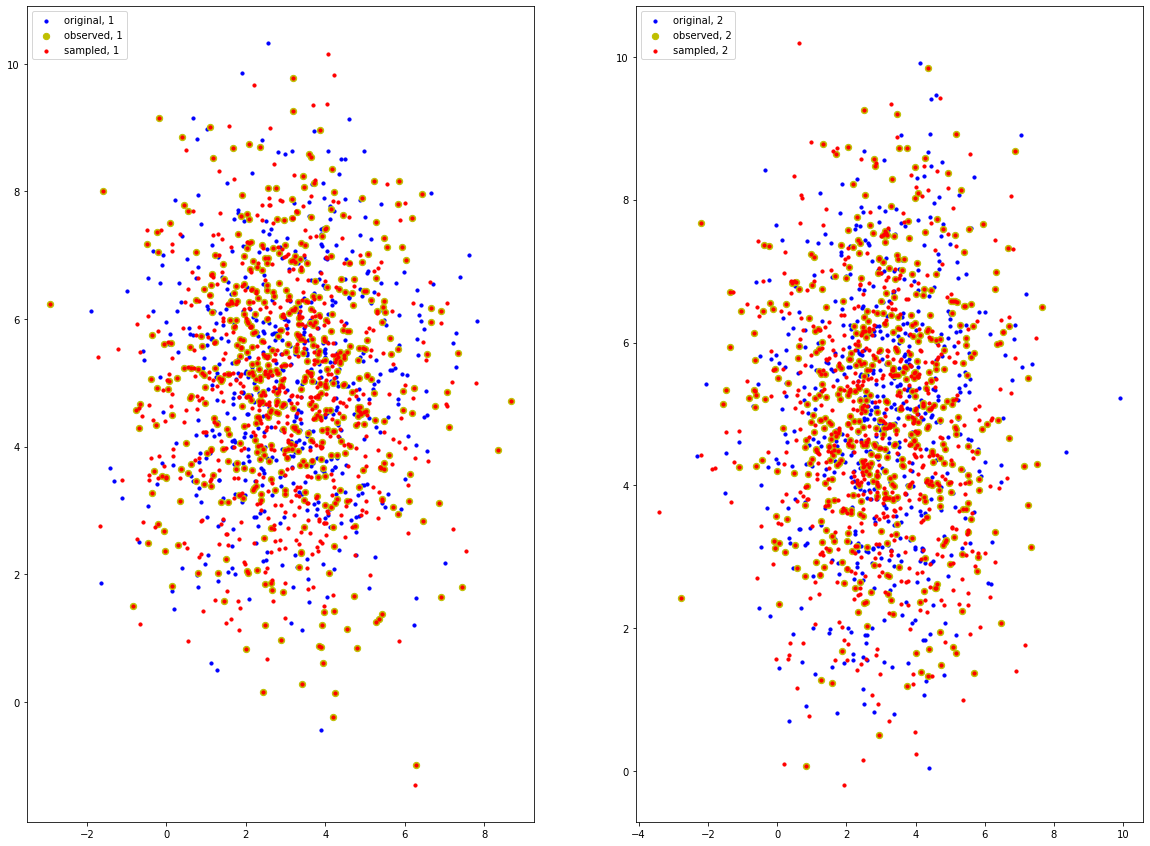

In [28]:
# Apply conditional (proximal optimization method) Langevin sampling to recover the original (generated) data
# Datapoints highlighted in RED represents sampled datapoints.

mask_sum = np.sum(mask, axis=0)
mask_sum[mask_sum == 0] = 1
def A(mask, x):
    return np.sum(mask * x, axis=0)

def At(mask, y):
    res = np.zeros_like(mask)
    for n in range(mask.shape[0]):
        res[n] = np.multiply(y, mask[n])
    return res

def get_scores(x, mask, meas):
    sigma = np.array([3, 3])
    sigma_2 = np.array([3, 3])
    mu = np.array([3, 5])
    
    score_x = (x - mu[None, None, None, :]) / sigma[None, None, None, :]
    return -1 * score_x

def cond_langevin_sampler(mask, meas, step_size=0.01, alpha=0.001):
    mean = np.array([0, 0])
    cov = np.eye(mean.shape[0])
    x = np.zeros(shape)[..., None]
    x = np.repeat(x, 2, -1)
    
    for i in range(2000):
        noise = np.sqrt(step_size) * rng.multivariate_normal(mean=mean, cov=cov, size=shape)
        scores = get_scores(x, mask, meas)
        x = x + step_size * scores / 2
        x = x + noise
        x = x + mask * (masked - x) # Proximal oracle step
    
    return x

def scatter_plot(data, masked, sampled):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    x_vec = np.ravel(data[0, :, :, 0])
    y_vec = np.ravel(data[0, :, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 1')
    
    x_vec = np.ravel(data[1, :, :, 0])
    y_vec = np.ravel(data[1, :, :, 1])
    ax2.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original, 2')
    
    x_vec = np.ravel(masked[0, :, :, 0][bool_mask[0]])
    y_vec = np.ravel(masked[0, :, :, 1][bool_mask[0]])
    ax1.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='observed, 1', facecolor='none')
    
    x_vec = np.ravel(masked[1, :, :, 0][bool_mask[1]])
    y_vec = np.ravel(masked[1, :, :, 1][bool_mask[1]])
    ax2.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='observed, 2', facecolor='none')
    
    x_vec = np.ravel(sampled[0, :, :, 0])
    y_vec = np.ravel(sampled[0, :, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='r', marker="o", label='sampled, 1', facecolor='none')
    ax1.legend(loc='upper left')

    x_vec = np.ravel(sampled[1, :, :, 0])
    y_vec = np.ravel(sampled[1, :, :, 1])
    ax2.scatter(x_vec,y_vec, s=10, c='r', marker="o", label='sampled, 2', facecolor='none')
    ax2.legend(loc='upper left')

x_hat_2 = cond_langevin_sampler(mask, meas)
scatter_plot(data, masked, x_hat_2)

# Notice how the sampled datapoints corresponding to the unmasked/observed (YELLOW) datapoints lie
# exactly ontop of each other.

# In this case, the sampled datapoints accurately matches the unmasked/observed datapoints. This assumes
# that our proximal optimization step is able to recover the unmasked datapoints perfectly (oracle)

# BLUE datapoints are masked (cannot be perfectly recovered), and their corresponding sampled datapoints
# is still consistent with the overall data distribution. This is the best we can achieve.

In [30]:

def mse(x_hat, x_hat_2, mask, masked, data):
    error = data - x_hat
    error = np.power(error, 2)
    error = np.sqrt(np.sum(error)) / np.cumprod(shape)[-1]
    print(f"MSE for unconditional sampling, ALL (unmasked + masked) datapoints: {error}")
    
    error = data - x_hat_2
    error = np.power(error, 2)
    error = np.sqrt(np.sum(error)) / np.cumprod(shape)[-1]
    print(f"MSE for conditional sampling, ALL (unmasked + masked) datapoints: {error}")

mse(x_hat, x_hat_2, mask, masked, data)

MSE for unconditional sampling, ALL (unmasked + masked) datapoints: 0.06288170807384617
MSE for conditional sampling, ALL (unmasked + masked) datapoints: 0.0436556379036644


In [31]:
# Normality test for both unconditional (x_hat) 
# and conditional sampled (x_hat_2) distribution

from scipy.stats import normaltest

k2_x, p_x = normaltest(np.ravel(x_hat[..., 0]))
k2_y, p_y = normaltest(np.ravel(x_hat_2[..., 0]))

alpha = 1e-3
print(f"p_x: {p_x}, normal: {True if p_x > alpha else False}")
print(f"p_y: {p_y}, normal: {True if p_y > alpha else False}")




p_x: 0.8326321860412517, normal: True
p_y: 0.06289623398495696, normal: True
